# Welcome to Computer Vision! #

Congratulations! You've just been hired as KaggleKars first data scientist! Are you ready?

<!-- TODO: HEADER ILLUSTRATION -->

In this micro-course, you'll:
- Design a state-of-the-art **image classifier** with Keras!
- Master the art of **transfer learning** to boost your models!
- See inside a **convolutional layer** <!-- visualize what the model learns -->
- Use the powerful **TPU accelerator** to speed-up your training!
- Utilize **data augmentation** to get more data--for free!

If you've taken the /Introduction to Deep Learning/ micro-course, you'll know everything you need to be successful.

Now let's get started!

# Classifying Cars #

KaggleKars, a new company, has an idea for an app. If someone sees a car they like, they can take a picture, and the app will suggest cars for sale nearby of the same kind. Your job is to design the **image classifier**. If a user uploads a picture like this: 

<!-- TODO: picture of car -->

your classifier should output the make, model, and year like this: 

<!-- TODO: class label -->

The company has decided for now to focus on a list of 196 different vehicles. They have collected a dataset consisting of 16,185 images of these vehicles, divided into a **training set** of 8,144 images and a **validation set** of 8,041 images. The company says that to be successful, they need the classifier to achieve **95% accuracy** on the validation set.

# Tensor Processing Units #

In this course, you'll be working with large models and large datasets. Training these models on an ordinary CPU would be very time consuming, and because of memory limitations, the accuracy of your model could suffer as well.

Instead, you'll train your models on a **Tensor Processing Unit** or **TPU**. A TPU is an accelerator much like the GPU you used in the introductory course. The TPUs that Kaggle provides, however, are able to handle much larger workloads than the GPUs.

<!-- TODO: picture of tpu -->

Because of their <!-- unique nature --> TPUs require some modifications to the workflow you might be more familiar with. So throughout this course, in addition to discussing deep learning, we'll also discuss <!-- tpus, data pipelines, how to take advantage of tpus, issues about tpus, the issues that go with using them well, these are the kinds of real-world problems you need to know about -->.

The result is worth the effort though. Models that could take weeks to train on a home computer can be trained in minutes on a cloud TPU. (And Kaggle gives you 30 hours each week for free!)

What's more, the methods that you'll learn in this course will scale to workloads many times as large. Essentially the same methods could be used to train the deep learning models like BERT and BigGan, which have billions of parameters. After completing this micro-course, you'll have tools to solve demanding real-world problems.

# Data Pipelines #

Instead of the Keras data loader you used in *Intro to Deep Learning*, we'll use a library called [TensorFlow Datasets](https://www.tensorflow.org/datasets) (TFDS). <!-- TODO: ask Alexis what she's using --> TPUs require data in a special kind of file called a *TFRecord*. TFDS provides a convenient way of loading these files.

<!-- TODO: simple builder config for cars dataset -->

In [12]:
import tensorflow_datasets as tfds
#from kaggle_datasets import KaggleDatasets
import visiontools
from visiontools import StanfordCars

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
DATA_DIR="/home/jovyan/work/kaggle/datasets"

#tfds.core.add_data_dir(KaggleDatasets.get_gcs_path())

ds_train, ds_info = tfds.load('stanford_cars/simple',
                                          with_info=True,
                                          split='train',
                                          as_supervised=False,
                                          data_dir=DATA_DIR,
                                          shuffle_files=True)

In the tutorial, we'll use a simplified version of the cars dataset that has 800 images in both the training and the validation datsets, divided into three classes: `Convertible`, `SUV`, and `Wagon`. In the exercises, you'll use the full dataset.

Let's take a look.

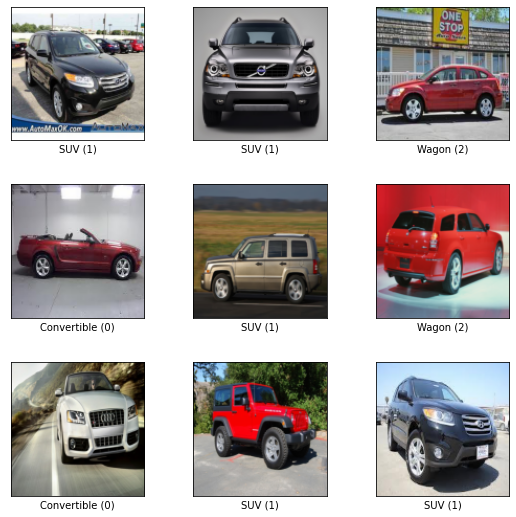

In [11]:
tfds.show_examples(ds_info, ds_train)

Now we'll set up the data pipeline.

In [14]:
import tensorflow as tf

BATCH_SIZE = 16
AUTO = tf.data.experimental.AUTOTUNE

(ds_train, ds_valid), ds_info = tfds.load('stanford_cars/simple',
                                          with_info=True,
                                          split=['train', 'test'],
                                          as_supervised=True,
                                          data_dir=DATA_DIR,
                                          shuffle_files=True)

ds_train = (
    ds_train.batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

ds_valid = (
    ds_valid.cache()
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

<!-- TODO: make sure the batch size is compatible with the size of the dataset -->

# Transfer Learning #

<!-- move most of this discussion to next lesson -->
- training an image classifier is hard, especially when you have a lot of labels
  - for instance, /this problem/ needed /this many/ examples to get to /X%/ accuracy
  - but you only have around /this many/ images per car! it you start from scratch, it won't be nearly enough
- fortunately, there's a way around this problem. It's called **transfer learning**.
- as complicated as the visual world is... visual data has a lot in common...
  - for instance, all pictures will have lines and curves, transitions from one color to another
  - (artists have known this for a long time... some artists say there are only x basic shapes! /link/)
  - so an image classifier trained on one dataset will already know most of what it needs to be successful on any other dataset, so why not reuse that information? that's the idea behind transfer learning!
- ImageNet contains over 14 million images in over 22,000 categories. Keras contains a number of powerful models that have been trained on ImageNet. And you can download them yourself!

As you'll learn in the next lesson, much of what image classifiers learn is the same across datasets. The topmost layers contain most of the learning unique to a dataset. The bottommost layers contain what is common to most natural images.

The insight of transfer learning is that if we remove those topmost layers, we can reuse the bottom part, the part that's most likely to generalize. <!-- last two paragraphs are awkward -->

The kinds of deep neural networks you'll be using in this course are called **convolutional neural networks**. They have two parts: a **dense head** and a **convolutional base**.

<!-- DIAGRAM: base/head -->

The base learns the features, and the head learns the classes. So to reuse a model trained on a different different classes, we want to keep the base, but train a new head. Additionally, we can "unfreeze" the topmost layers of the base so that they too will adapt to the new dataset.

<!-- DIAGRAM: show swapping:imagenet to cars -->

Here is the Keras code that defines a convolutional network with transfer learning.

In [21]:
SIZE = [128, 128]
NUM_LABELS = 3

# Load the pretrained VGG16 model
pretrained_model = tf.keras.applications.VGG16(weights='imagenet',
                                               include_top=True,
                                               input_shape=[*SIZE, 3])
# Unfreeze the weights for fine-tuning
pretrained_model.trainable = False
# Construct the model
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(NUM_LABELS,
                          activation='softmax',
                          dtype=tf.float32)
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

You can see that the pretrained model is called **VGG16**. It is smaller than many modern convnets, but large enough to not be a "toy" model. Its size is appropriate for our smaller example dataset.

# Train the Model #

In [22]:
EPOCHS = 4

history = model.fit(ds_train,
                    validation_data=ds_valid,
                    epochs=EPOCHS)

Epoch 1/4
171/171 [==============================] - 180s 1s/step - loss: 2.5638 - accuracy: 0.6277 - val_loss: 1.6726 - val_accuracy: 0.6665
Epoch 2/4
171/171 [==============================] - 180s 1s/step - loss: 1.3405 - accuracy: 0.7355 - val_loss: 1.2950 - val_accuracy: 0.7052
Epoch 3/4
171/171 [==============================] - 181s 1s/step - loss: 0.9757 - accuracy: 0.7722 - val_loss: 1.1334 - val_accuracy: 0.7238
Epoch 4/4
171/171 [==============================] - 187s 1s/step - loss: 0.7750 - accuracy: 0.7953 - val_loss: 1.0430 - val_accuracy: 0.7264


<!-- TODO: put callbacks in visiontools? how successful without? -->

The `history` object contains information about the training in a dictionary `history.history`. We can use Pandas to convert this dictionary to a dataframe and plot it with a built-in method.

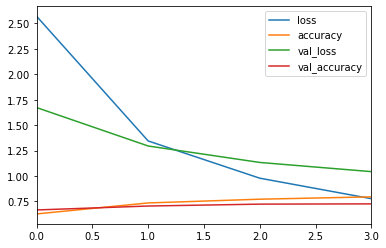

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot();

<!-- discuss convergence, over/underfitting -->

# Evaluate #

Now let's see how our classifier performed.

<!-- TODO: classification report -->

In [ ]:
from sklearn.metrics import classification_report

# label_names =
# true_labels =
# predicted_labels =
classification_report(true_labels, predicted_labels, target_names=label_names)

<!-- TODO: plot_confusion_matrix in visiontools -->

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cmat = confusion_matrix(true_labels, predicted_labels, label_names)
sns.heatmap(cmat, cmap='Blues');

Let's think about it.

# Conclusion #


# Your Turn #